<font size="6"> **Model Building** </font>

In [1]:
%%capture
%run 00_mlmod_load_data.ipynb

In [2]:
RND_SEED = 123
KFOLDS = 3
pd.set_option('precision', 4)


In [3]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

# Scoring Function

In [4]:
def direction_accuracy_func(y_true, y_pred, **kwargs):
    kind = kwargs.get('kind', 'global')
    w_fp = kwargs.get('w_fp', 2)
    w_fn = kwargs.get('w_fn', 2)
    nobs = len(y_true)
    y_true_pos = (y_true>0).astype(int)
    y_pred_pos = (y_pred>0).astype(int)
    xtab = pd.crosstab(index=y_true_pos, columns=y_pred_pos)
    try:
        tp = xtab.loc[1,1]
    except:
        tp = 0
    try:
        tn = xtab.loc[0,0]
    except:
        tn = 0
    try:
        fp = xtab.loc[0,1]
    except:
        fp = 0
    try:
        fn = xtab.loc[1,0]
    except:
        fn = 0
    if kind == 'global':
        try:
            acc = (tp + tn)/nobs
        except:
            acc = 0
    elif kind == 'upwards':
        try:
            acc = tp/(tp + fn)
        except:
            acc = 0
    elif kind == 'downwards':
        try:
            acc = tn/(tn + fp)
        except:
            acc = 0
    elif kind == 'weighted':
        try:
            acc = (tp + tn)/(tp + tn + fp*w_fp + fn*w_fn)
        except:
            acc = 0
    else:
        raise ValueError("kind must be: global, upwards, downwards or weighted")
        
    return acc
direction_accuracy = make_scorer(direction_accuracy_func, greater_is_better=True, kind='global')
upwards_direction_accuracy = make_scorer(direction_accuracy_func, greater_is_better=True, kind='upwards')
downwards_direction_accuracy = make_scorer(direction_accuracy_func, greater_is_better=True, kind='downwards')
weighted_direction_accuracy = make_scorer(direction_accuracy_func, greater_is_better=True, kind='weighted', w_fp=2., w_fn=1.)

In [5]:
y_true = np.array([0.1, -0.1, 0.2, -0.2, -0.15])
y_pred = np.array([0.01, 0.01, -0.02, -0.02, -0.15])
pd.crosstab(index=(y_true>0).astype(int), columns=(y_pred>0).astype(int))

col_0,0,1
row_0,,
0,2,1
1,1,1


In [6]:
direction_accuracy_func(y_true, y_pred)

0.6

In [7]:
direction_accuracy_func(y_true, y_pred, kind='upwards')

0.5

In [8]:
direction_accuracy_func(y_true, y_pred, kind='downwards')

0.6666666666666666

In [9]:
direction_accuracy_func(y_true, y_pred, kind='weighted', w_fp=2, w_fn=1.5)

0.46153846153846156

In [10]:
scoring = {'neg_root_mean_squared_error':'neg_root_mean_squared_error',
           'w_accuracy': weighted_direction_accuracy,
           'accuracy': direction_accuracy,
          'up_accuracy': upwards_direction_accuracy,
          'down_accuracy': downwards_direction_accuracy}

In [11]:
select_sum_cols = ['mean_test_w_accuracy', 'std_test_w_accuracy', 'rank_test_w_accuracy',
                   'mean_test_accuracy', 'mean_test_up_accuracy','mean_test_down_accuracy', 'mean_test_neg_root_mean_squared_error']

In [12]:
(y_train_smp>0).value_counts()

True     32504
False    25279
Name: target, dtype: int64

# Ridge Models

In [13]:
ridge_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)

In [14]:
hpgrid_ridge = {'alpha': [10.0**x for x in range(-3,3)]}
ridge = Ridge(fit_intercept=False, random_state=RND_SEED)

In [15]:
ridge_cv = GridSearchCV(ridge, hpgrid_ridge, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=ridge_tscv_smp, return_train_score=True)
res_ridge_cv = ridge_cv.fit(X_train_smp[features], y_train_smp)

In [16]:
ridge_params_df = pd.DataFrame(res_ridge_cv.cv_results_['params'])
ridge_metrics_df = pd.DataFrame(res_ridge_cv.cv_results_)[select_sum_cols]
ridge_sum_df = ridge_params_df.join(ridge_metrics_df)
ridge_sum_df.sort_values(by='rank_test_w_accuracy').head(20)

,alpha,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
0,0.001,0.4435,0.0275,1,0.5480,0.6188,0.4600,-0.0287
1,0.010,0.4387,0.0205,2,0.5589,0.7015,0.3788,-0.0286
2,0.100,0.4378,0.0184,3,0.5619,0.7227,0.3584,-0.0286
3,1.000,0.4367,0.0168,4,0.5624,0.7309,0.3487,-0.0286
4,10.000,0.4200,0.0070,5,0.5624,0.8211,0.2361,-0.0285
5,100.000,0.3866,0.0113,6,0.5546,0.9806,0.0264,-0.0287


In [17]:
res_ridge_cv.best_score_

0.44353819235148345

In [18]:
champ_ridge_hparms = res_ridge_cv.cv_results_['params'][2]
champ_ridge = Ridge(fit_intercept=False, random_state=RND_SEED)
champ_ridge.set_params(**champ_ridge_hparms)
champ_ridge.fit(X_train_smp[features], y_train_smp)

Ridge(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)

In [19]:
p_test_ridge = pd.Series(index=y_test_full.index, data=champ_ridge.predict(X_test_full[features]))

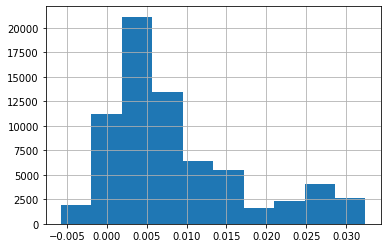

In [20]:
p_test_ridge.hist()

In [21]:
ridge_sum_df = mle_utils.predict_and_score(champ_ridge,
                                           X_train_full[features], y_train_full,
                                           X_test_full[features], y_test_full, kind='reg')
ridge_sum_df

train_pmean           0.0035
train_score           0.0008
valid_pmean           0.0086
valid_score           0.0015
train_acc_target<0    0.3056
train_acc_target>0    0.7847
train_acc             0.5751
valid_acc             0.5043
valid_acc_target<0    0.0983
valid_acc_target>0    0.9024
dtype: float64

In [35]:
direction_accuracy_func(y_test_full, p_test_ridge, kind='downwards')

0.09830644929411426

In [22]:
# overlapper

# Random Forest Model

In [23]:

rf_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)

In [24]:
hpgrid_rf = {'max_samples': [0.25, 0.5, 0.75],
            'max_features': [0.25, 0.5, 0.75],
            'min_samples_leaf': [250, 500, 1000, 2500, 5000]}
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)

In [25]:
rf_cv = GridSearchCV(rf, hpgrid_rf, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=rf_tscv_smp, return_train_score=True)
res_rf_cv = rf_cv.fit(X_train_smp, y_train_smp)

In [26]:
rf_params_df = pd.DataFrame(res_rf_cv.cv_results_['params'])
rf_metrics_df = pd.DataFrame(res_rf_cv.cv_results_)[select_sum_cols]
rf_sum_df = rf_params_df.join(rf_metrics_df)
rf_sum_df.sort_values(by='rank_test_w_accuracy').head(20)

,max_features,max_samples,min_samples_leaf,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
30,0.75,0.25,250,0.4403,0.0351,1,0.4975,0.3437,0.6884,-0.0292
41,0.75,0.75,500,0.4380,0.0302,2,0.4991,0.3612,0.6715,-0.0293
26,0.50,0.75,500,0.4355,0.0318,3,0.5056,0.4134,0.6196,-0.0290
15,0.50,0.25,250,0.4339,0.0276,4,0.5006,0.3890,0.6370,-0.0290
36,0.75,0.50,500,0.4331,0.0216,5,0.4926,0.3416,0.6800,-0.0292
35,0.75,0.50,250,0.4264,0.0345,6,0.5158,0.5144,0.5200,-0.0291
21,0.50,0.50,500,0.4263,0.0334,7,0.4948,0.3958,0.6168,-0.0290
20,0.50,0.50,250,0.4244,0.0275,8,0.5062,0.4671,0.5554,-0.0289
10,0.25,0.75,250,0.4216,0.0277,9,0.5278,0.6116,0.4171,-0.0288
25,0.50,0.75,250,0.4208,0.0307,10,0.5136,0.5299,0.4965,-0.0289


In [27]:
res_rf_cv.best_score_

0.44031411728200437

In [52]:
champ_rf_hparms = res_rf_cv.cv_results_['params'][41]
champ_rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)
champ_rf.set_params(**champ_rf_hparms)
champ_rf.fit(X_train_smp, y_train_smp)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.75, max_leaf_nodes=None,
                      max_samples=0.75, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=500,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=123, verbose=0, warm_start=False)

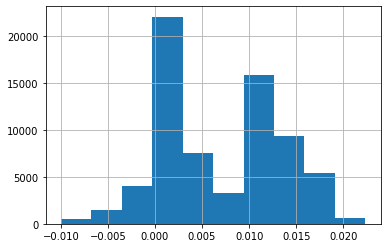

In [53]:
p_test_rf = pd.Series(index=y_test_full.index, data=champ_rf.predict(X_test_full))
p_test_rf.hist()

In [29]:
p_test_rf = pd.Series(index=y_test_full.index, data=champ_rf.predict(X_test_full))

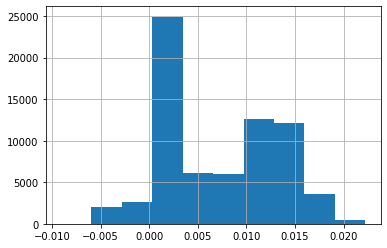

In [30]:
p_test_rf.hist()

In [45]:
direction_accuracy_func(y_test_full, p_test_rf, kind='global')

0.5159820602263828

In [54]:
direction_accuracy_func(y_test_full, p_test_rf, kind='downwards')

0.11731217113775554

In [47]:
rf_sum_df = mle_utils.predict_and_score(champ_rf,
                                        X_train_full, y_train_full,
                                        X_test_full, y_test_full, kind='reg')
rf_sum_df

train_pmean           0.0036
train_score           0.0007
valid_pmean           0.0070
valid_score           0.0014
oob_score             0.1406
train_acc_target<0    0.4749
train_acc_target>0    0.8118
train_acc             0.6643
valid_acc             0.5160
valid_acc_target<0    0.0620
valid_acc_target>0    0.9613
dtype: float64